## Importamos el excel

In [72]:
import pandas as pd

# Ruta al archivo Excel
file_path = '/home/jovyan/work/transcripciones_frases.xlsx'

# Cargamos el archivo Excel
df = pd.read_csv(file_path)

# Verificar que las columnas existen
assert 'Texto Original' in df.columns, "La columna 'Texto Original' no existe en el archivo Excel"
assert 'Texto Corregido' in df.columns, "La columna 'Texto Corregido' no existe en el archivo Excel"

df.head()


FileNotFoundError: [Errno 2] No such file or directory: '/home/jovyan/work/transcripciones_frases.csv'

## Dividimos el conjunto de datos en conjuntos de entrenamiento y validación

In [54]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

train_df.head()


,Texto Original,Texto Corregido
0,[Música] esto es importante para cada adulto o...,Esto es importante para cada adulto o cada per...
7,[Música] [Música] [Música] más [Música] voy a ...,"Hola, voy a explicarte todo lo que te extraño...."
2,Qué pasa chicos eh estoy aquí un poco a oscura...,¿Qué pasa chicos? Estoy aquí un poco a oscuras...
4,Estamos en uno de los trenes\nmás costosos de ...,Estamos en uno de los trenes más costosos de t...
3,mi gente de Perú qué tal estáis ayer nos queda...,"Mi gente de Perú, ¿qué tal estáis? Ayer nos qu..."


## Usaremos el modelos T5. Tokenizamos antes de introducir el texto en el modelo con T5Tokenizer 
### Se puede usar 't5-base' o 't5-large' según lo preciso (más tiempo de entrenamiento) que queramos entrenar el modelo 

In [55]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Carga el tokenizador y el modelo
model_name = 't5-base'  
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# Función para tokenizar y preparar los datos
def preprocess_data(data, tokenizer, max_len=512):
    inputs = [f"corrija: {text}" for text in data['Texto Original']]
    targets = [text for text in data['Texto Corregido']]
    
    input_encodings = tokenizer(inputs, truncation=True, padding=True, max_length=max_len)
    target_encodings = tokenizer(targets, truncation=True, padding=True, max_length=max_len)
    
    return {
        'input_ids': input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Creación del Dataset de entrenamiento y validacion

In [56]:
# Preprocesar los datos
train_encodings = preprocess_data(train_df, tokenizer)
val_encodings = preprocess_data(val_df, tokenizer)

In [57]:
import torch
from torch.utils.data import Dataset

# Crear un dataset personalizado para el modelo T5
class TextCorrectionDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

# Crear datasets de entrenamiento y validación
train_dataset = TextCorrectionDataset(train_encodings)
val_dataset = TextCorrectionDataset(val_encodings)

In [58]:
from transformers import Trainer, TrainingArguments, T5ForConditionalGeneration

# Configurar los argumentos del entrenamiento
training_args = TrainingArguments(
    output_dir='./results',          # Directorio de salida
    num_train_epochs=3,              # Épocas
    per_device_train_batch_size=8,   # Tamaño del lote de entrenamiento
    per_device_eval_batch_size=8,    # Tamaño del lote de evaluación
    warmup_steps=500,                # Pasos de calentamiento
    weight_decay=0.01,               # Desintegración del peso
    logging_dir='./logs',            # Directorio de logs
    evaluation_strategy="epoch",
    save_strategy="epoch",
    report_to="none",                # Evitar el logging a WandB
    fp16=True                        # Habilitar el entrenamiento en punto flotante de 16 bits para mejorar el rendimiento en GPU
)

# Crear el entrenador
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)



/opt/conda/lib/python3.11/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


## Entrenamiento del modelo

In [59]:
# Entrenamiento del modelo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Iniciar el entrenamiento
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,15.453381
2,No log,15.450224
3,No log,15.443916


TrainOutput(global_step=3, training_loss=14.281431833902994, metrics={'train_runtime': 270.1296, 'train_samples_per_second': 0.067, 'train_steps_per_second': 0.011, 'total_flos': 10961242030080.0, 'train_loss': 14.281431833902994, 'epoch': 3.0})

# Evaluación del modelo



In [60]:
# Verificar los datos tokenizados
print("Ejemplo de input_ids:", train_encodings['input_ids'][:1])
print("Ejemplo de labels:", train_encodings['labels'][:1])

Ejemplo de input_ids: [[4301, 22276, 9, 10, 784, 329, 2, 7, 2617, 908, 259, 32, 3, 15, 7, 7158, 3856, 3, 17436, 3165, 32, 3, 32, 3, 17436, 568, 9, 238, 20, 10301, 2002, 32, 142, 108, 295, 9, 3165, 9, 5569, 835, 14124, 9, 3, 15, 40, 2202, 20, 73, 25506, 32, 3, 35, 3, 15, 40, 238, 9489, 15, 3972, 1870, 291, 44, 52, 2975, 7, 3, 63, 3, 7290, 49, 291, 150, 5394, 23, 4922, 12, 26, 32, 3, 287, 32, 238, 52, 2, 9, 3972, 7683, 15, 73, 8524, 35, 3, 9, 2, 32, 231, 32, 3, 28061, 7158, 3, 9, 2, 29, 50, 554, 122, 14016, 238, 2844, 3, 35, 509, 397, 3, 15, 40, 576, 7275, 15742, 5569, 835, 2844, 836, 1122, 883, 4557, 9, 399, 32, 30738, 23, 154, 29, 3, 2720, 26, 32, 3, 75, 4922, 51, 32, 7637, 2975, 3, 15, 40, 3, 9, 2, 32, 238, 3, 287, 23, 35, 1629, 3, 9, 6899, 13332, 32, 20, 249, 420, 548, 2975, 7, 3, 60, 17, 9300, 7664, 3, 7, 22881, 7108, 15, 75, 2, 9, 7, 4035, 63, 29404, 7923, 9, 7, 12, 7664, 6377, 77, 14073, 5569, 10381, 3, 28061, 3, 17962, 813, 23414, 7, 20, 50, 936, 15644, 3, 17, 15, 554, 1926, 839,

In [61]:
# Verificar el proceso de entrenamiento
print(trainer.state.log_history)


[{'eval_loss': 15.453380584716797, 'eval_runtime': 2.023, 'eval_samples_per_second': 0.989, 'eval_steps_per_second': 0.494, 'epoch': 1.0, 'step': 1}, {'eval_loss': 15.450223922729492, 'eval_runtime': 3.0415, 'eval_samples_per_second': 0.658, 'eval_steps_per_second': 0.329, 'epoch': 2.0, 'step': 2}, {'eval_loss': 15.443916320800781, 'eval_runtime': 1.8716, 'eval_samples_per_second': 1.069, 'eval_steps_per_second': 0.534, 'epoch': 3.0, 'step': 3}, {'train_runtime': 270.1296, 'train_samples_per_second': 0.067, 'train_steps_per_second': 0.011, 'total_flos': 10961242030080.0, 'train_loss': 14.281431833902994, 'epoch': 3.0, 'step': 3}]


In [62]:
# Generar predicciones para el conjunto de validación
predictions = trainer.predict(val_dataset)

# Verificar las predicciones
print("Predicciones des-tokenizadas:", pred_texts[:5])
print("Etiquetas reales des-tokenizadas:", label_texts[:5])

Predicciones des-tokenizadas: ['hice un top al respecto hace muchos aos y leer los comentarios de personas con el don de la imaginación a quienes se les retorcan las tripas poniéndose en el lugar de las personas que sufrieron aquellas s ad  usó placer por eso  hetescadidciónción', 'é tal  eazonado con tinta con el sabor de las noticias del da de hoy  y madre güey  hay carriles t com com  y ssazo [igagos bien igas bien venidos,a una edición más de luisillo el gordillo  esta ocasión nos hemosede']
Etiquetas reales des-tokenizadas: ['ya hice un top al respecto hace muchos aos y leer los comentarios de personas con el don de la imaginación a quienes se les retorcan las tripas poniéndose en el lugar de las personas que sufrieron aquellas horribles situaciones me causó placer. por eso, he aqu la secuela, una an mucho más grotesca que el primer top. lo que verás a continuación, todo peor que las más sórdidas pelculas de horror y gore actuales, lo sufrieron seres humanos reales y como sus seme

In [63]:

# Evaluación del modelo
eval_results = trainer.evaluate()
print(f"Resultados de la evaluación: {eval_results}")

Resultados de la evaluación: {'eval_loss': 15.443916320800781, 'eval_runtime': 2.8135, 'eval_samples_per_second': 0.711, 'eval_steps_per_second': 0.355, 'epoch': 3.0}


In [64]:
# Generar predicciones para el conjunto de validación
predictions = trainer.predict(val_dataset)

# Verificar la estructura de las predicciones
print("Tipo de predictions.predictions:", type(predictions.predictions))
print("Número de elementos en predictions.predictions:", len(predictions.predictions))

# Desglosar la tupla
logits = predictions.predictions[0] if isinstance(predictions.predictions, tuple) else predictions.predictions

# Convertir las predicciones a enteros usando argmax
pred_ids = logits.argmax(axis=-1)

# Verificar el contenido de las predicciones
print("Ejemplo de logits:", logits[0][:5])

# Des-tokenizar las predicciones y las etiquetas reales
pred_texts = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
label_texts = tokenizer.batch_decode(predictions.label_ids, skip_special_tokens=True)

# Verificar las longitudes de pred_texts y label_texts
print(f"Longitud de pred_texts: {len(pred_texts)}")
print(f"Longitud de label_texts: {len(label_texts)}")

# Verificar las predicciones y etiquetas des-tokenizadas
print("Predicciones des-tokenizadas:", pred_texts[:5])
print("Etiquetas reales des-tokenizadas:", label_texts[:5])

# Asegurarse de que los datos estén correctamente preparados
# Eliminar espacios en blanco y convertir a minúsculas para evitar errores de comparación
pred_texts = [text.strip().lower() for text in pred_texts]
label_texts = [text.strip().lower() for text in label_texts]

# Imprimir ejemplos para verificar la alineación (hasta un máximo de la longitud mínima)
for i in range(min(5, len(pred_texts), len(label_texts))):
    print(f"Predicción: {pred_texts[i]}")
    print(f"Etiqueta: {label_texts[i]}")

Tipo de predictions.predictions: <class 'tuple'>
Número de elementos en predictions.predictions: 2
Ejemplo de logits: [[-32.163067  -29.19463   -28.127296  ... -69.58027   -69.56299
  -69.74524  ]
 [-16.972902  -10.058041   -7.5320764 ... -37.781715  -37.854073
  -37.925556 ]
 [-28.785854  -14.288473   -6.617447  ... -38.134148  -38.245087
  -38.173817 ]
 [-34.18417   -17.636963   -9.58375   ... -46.088306  -46.104504
  -45.943398 ]
 [-18.926008  -11.6651125  -9.343887  ... -42.150307  -42.1697
  -42.32402  ]]
Longitud de pred_texts: 2
Longitud de label_texts: 2
Predicciones des-tokenizadas: ['hice un top al respecto hace muchos aos y leer los comentarios de personas que el don de la imaginación yquelenes su le suretorcan las tripas poniéndose en el lugar de s personas que sufrieron aquelloss s aciones  usó placer por  eso  e', 'é tal  eazonado con tinta con el sabor de las noticias de ho da de hoy  y madre güey  hay carriles  A Ty St  igagos am igas  venidos a un pa edición más lisill

In [65]:
# Calcular las métricas de evaluación
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(label_texts, pred_texts)
precision = precision_score(label_texts, pred_texts, average='weighted')
recall = recall_score(label_texts, pred_texts, average='weighted')
f1 = f1_score(label_texts, pred_texts, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


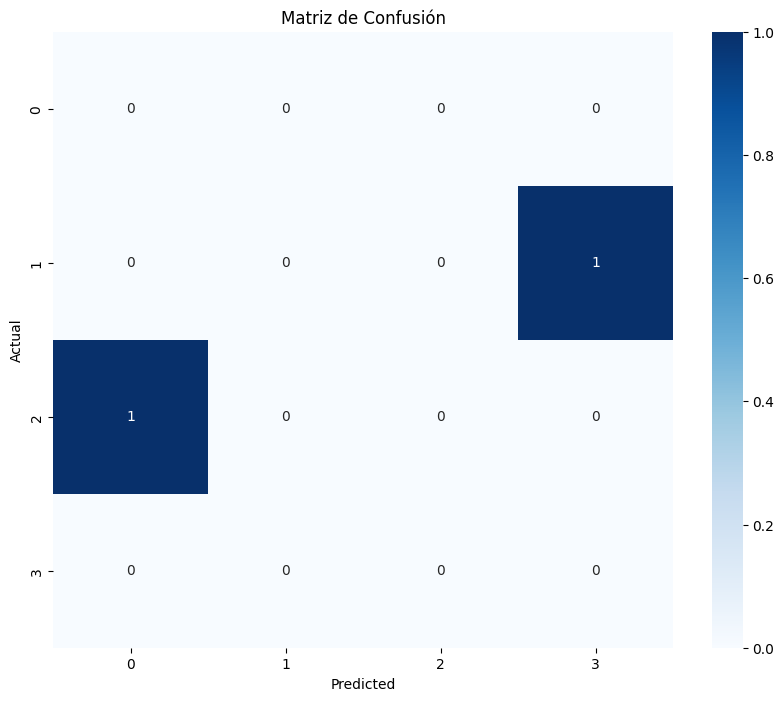

In [66]:

# Generar la matriz de confusión
conf_matrix = confusion_matrix(label_texts, pred_texts)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()


In [67]:
# Almacenamos el modelo entrenado
# model.save_pretrained('/home/jovyan/work/modelo_corregido')
# tokenizer.save_pretrained('/home/jovyan/work/modelo_corregido')
